# Элементарные алгоритмы обработки временных рядов

In [ ]:
Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба 
эти варианта моделями из класса MA. 
Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
dowjones_closing = pd.read_csv("/home/lena/Netology/Time_Series/Series/weekly-closings-of-the-dowjones-.csv")

In [4]:
from statsmodels.tsa.stattools import adfuller

In [5]:
from scipy.stats import boxcox

In [6]:
X_nostat = dowjones_closing.Close

In [7]:
X = boxcox(X_nostat, 0)

In [8]:
dftest = adfuller(X, autolag='AIC')
pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

Test Statistic                  -1.210369
p-value                          0.669119
#Lags Used                       0.000000
Number of Observations Used    161.000000
dtype: float64

In [9]:
import numpy as np
X = np.diff(X, 1)

In [10]:
dftest = adfuller(X, autolag='AIC')
pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
dtype: float64

In [11]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [12]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

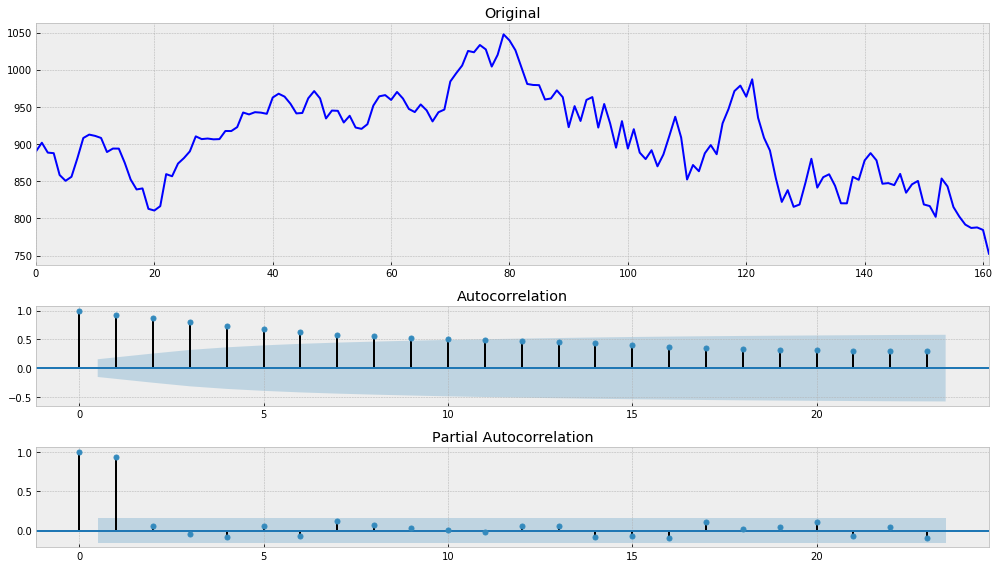

In [13]:
tsplot(X_nostat)

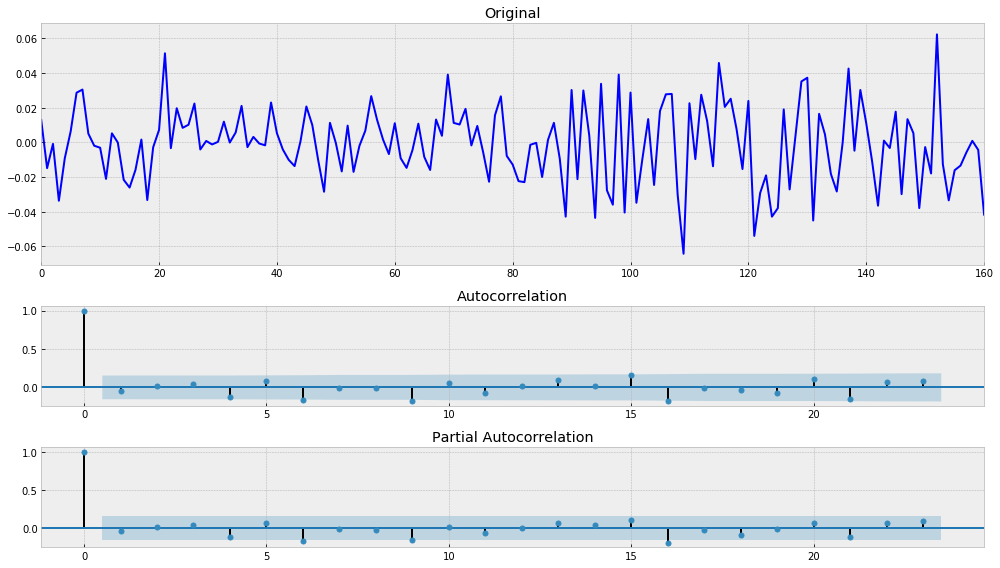

In [14]:
tsplot(X)

In [ ]:
У нас есть ряд X_nostat - оригинальный нестационарный ряд, 
а ряд X - стационарный (после применения Бокса-Кокса и дифференцирования).

In [ ]:
Применим стандартные алгоритмы к нашем рядам:
    1. Скользящее среднее
    2. Взвешенное скользящее среднее
    3. Экспоненциальное сглаживание

In [15]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [16]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [17]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [18]:
ema = exponential_moving_average(X_nostat, 0.7)
wma = weighted_moving_average(X_nostat, 5, [1,1,2,3,5])
ma = moving_average(X_nostat, 5)

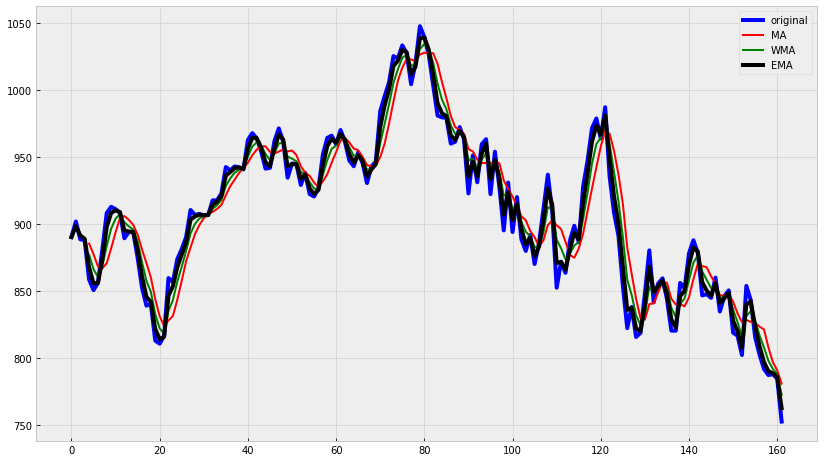

In [19]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(X_nostat, color='blue',  linewidth='4', label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

In [ ]:
Видим, что для оригинального ряда экспоненциальное сглаживание хорошо описывает наш ряд.

In [20]:
ema = exponential_moving_average(X, 0.7)
wma = weighted_moving_average(X, 5, [1,1,2,3,5])
ma = moving_average(X, 5)

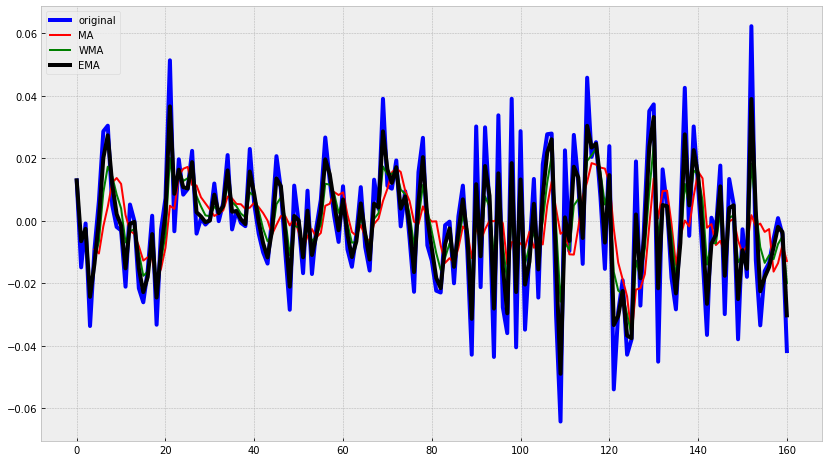

In [21]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(X, color='blue',  linewidth='4', label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

In [ ]:
Для стационарного ряда экспоненциальное сглаживание хорошо попадает в частотность, но иногда не видит пиков.

In [ ]:
Применим метод Хольта-Винтерса:

In [22]:
i=0
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [23]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [24]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [25]:
def plot_tema(alpha, beta, gamma, ser=X_nostat, ser_to_plot=X_nostat, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue', linewidth='4', label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

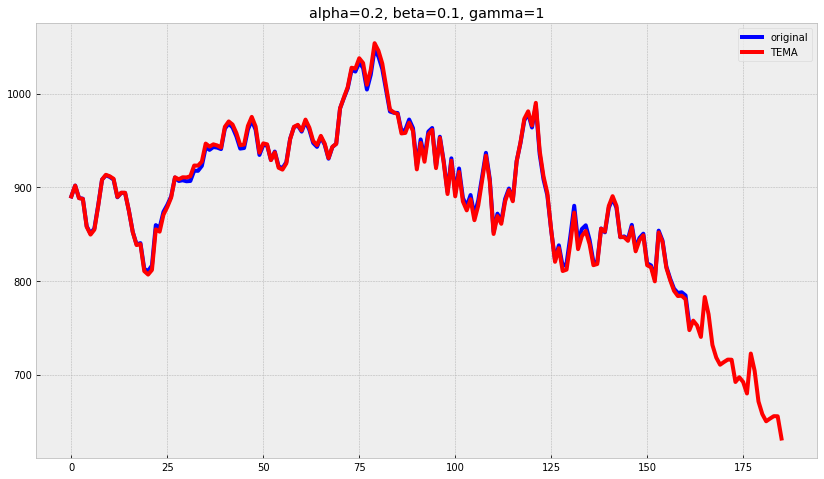

In [26]:
plot_tema(0.2, 0.1, 1)

In [27]:
def plot_tema(alpha, beta, gamma, ser=X, ser_to_plot=X, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue', linewidth='4', label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

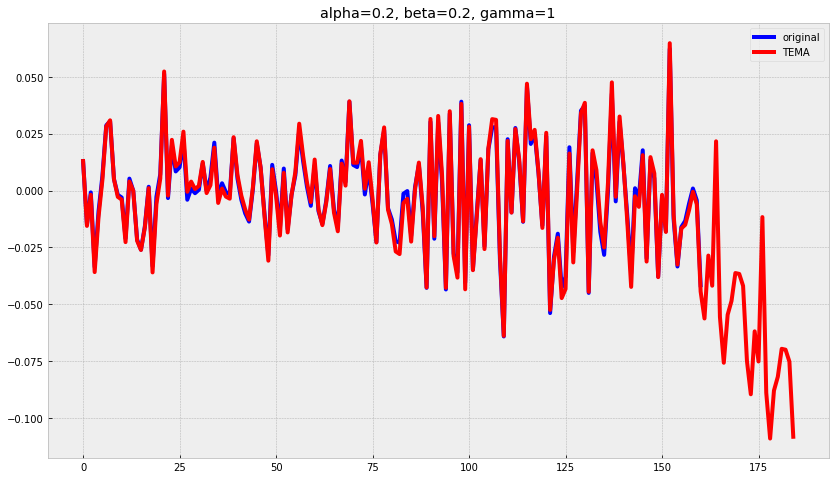

In [28]:
plot_tema(0.2, 0.2, 1)

In [ ]:
Видим, что данный метод очень хорошо описал наши ряды и сделал приемлимый прогноз. 

In [ ]:
Попробуем метод двойного экспоненциального сглаживания.

In [29]:
series = X_nostat

In [30]:
def double_ema(series, alpha, beta, n_preds=0):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [31]:
def plot_dema(alpha, beta, series, ser_to_plot=series, n_preds=0):
    dema = double_ema(X_nostat, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(X_nostat, color='blue',linewidth='4', label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

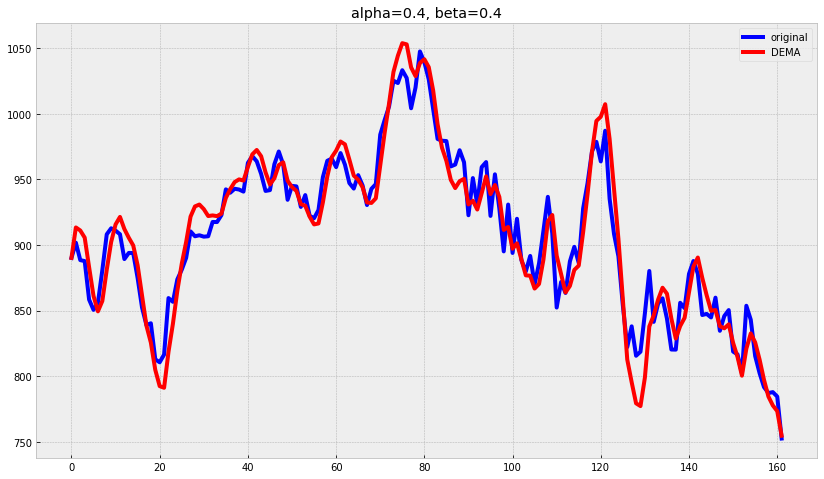

In [32]:
plot_dema(0.4, 0.4, series)

In [33]:
series = X

In [34]:
def plot_dema(alpha, beta, series, ser_to_plot=series, n_preds=0):
    dema = double_ema(X, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(X, color='blue',linewidth='4', label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

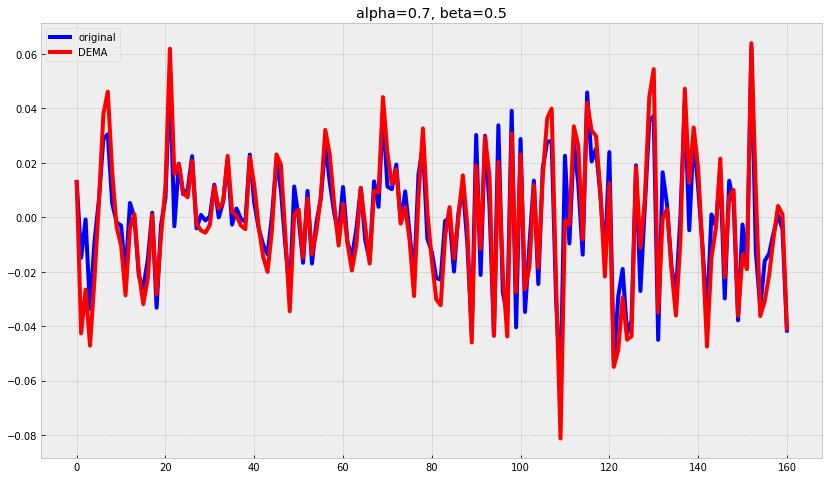

In [35]:
plot_dema(0.7, 0.5, series)

In [ ]:
Видим, что метод Хольта-Винтерса отработал лучше, чем метод двойного экспоненциального сглаживания. 

In [ ]:
Подберем наилучшие коэффициенты:

In [36]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [37]:
series = X_nostat

In [38]:
train, test, val = series[:60], series[60:70], series[70:]

In [39]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [40]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [41]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 52.340237053320934
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.67688086e-04,  2.00088834e-03,  2.55795385e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 124
      nit: 17
   status: 0
  success: True
        x: array([0.36836996, 0.01087965, 0.38611421])


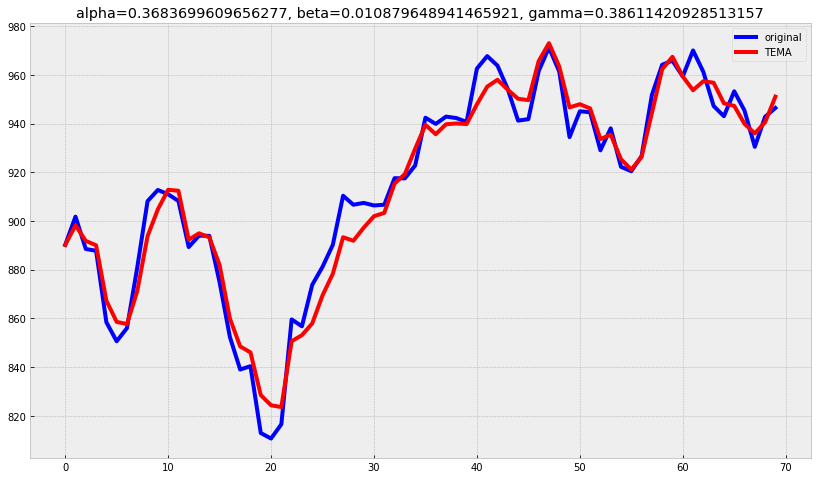

In [42]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

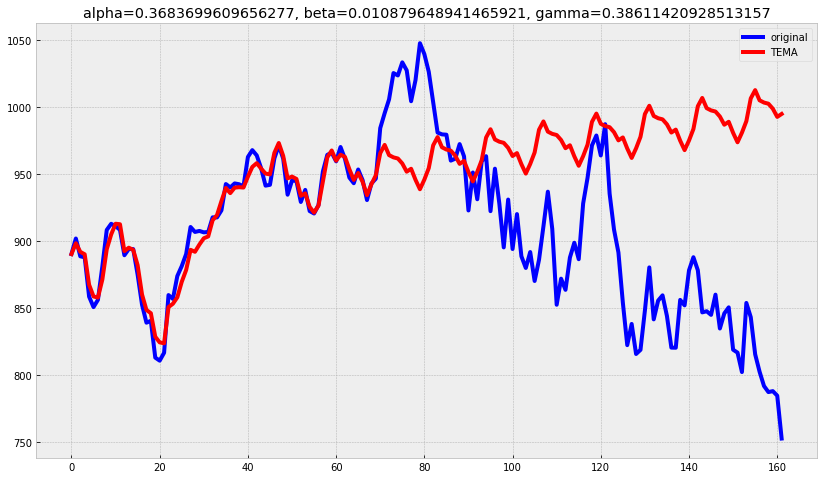

In [43]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))

In [44]:
series = X

In [45]:
train, test, val = series[:60], series[60:70], series[70:]

In [46]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [47]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [48]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.00013349698733321533
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.25941053e-07,  1.21837864e-04, -1.15455497e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 44
      nit: 10
   status: 0
  success: True
        x: array([0.02114327, 0.        , 0.00429633])


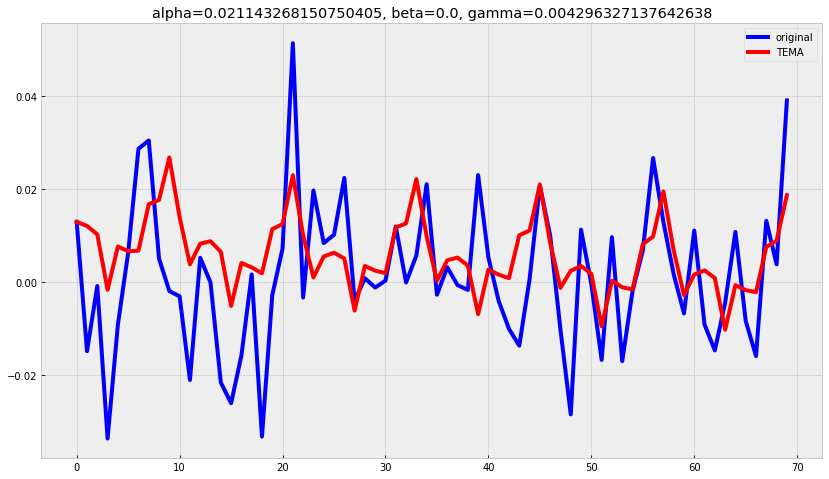

In [49]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

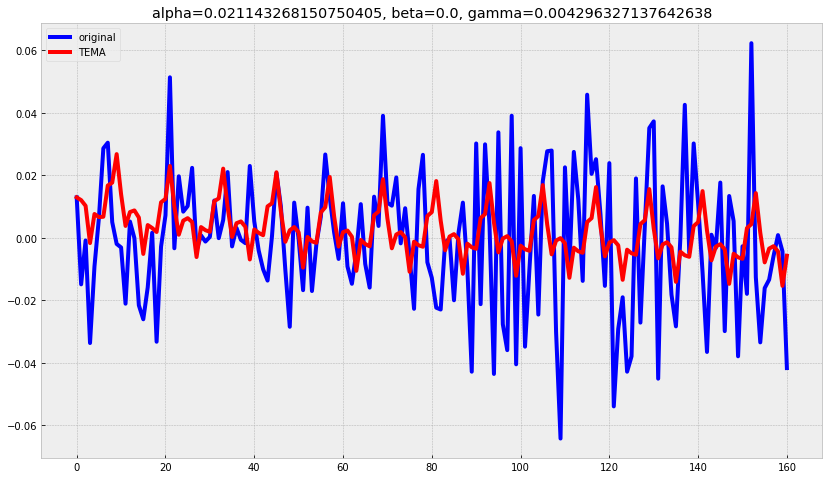

In [50]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))